In [1]:
import torch
import glob
import cv2
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from xml.dom.minidom import parse
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
idx2label = ["__background__", "person", "bicycle", "car", "motorbike", "bus"]
label2idx = {label:idx for idx, label in enumerate(idx2label)}

In [4]:
def get_image_data(img_name_list, data_dir = "./data/Image/"):
    image_data = dict()
    for image_file in img_name_list:
        image_filename = os.path.join(data_dir, image_file + ".png")
        image_data[image_file] = torch.Tensor(cv2.imread(image_filename)).permute(2,0,1)
    return image_data

In [5]:
def get_annotations_data(annotations_list, data_dir = "./data/Annotations/"):
    annotations_data = dict()
    for annotations in annotations_list:
        domTree = parse(os.path.join(data_dir, annotations+".xml"))
        rootNode = domTree.documentElement
        obj_list = rootNode.getElementsByTagName("object")
        label_list = []
        boxes_list = []
        for obj in obj_list:
            label_list.append(int(label2idx[obj.getElementsByTagName("name")[0].firstChild.data]))
            boxes_list.append([
                    float(obj.getElementsByTagName("bndbox")[0].getElementsByTagName("xmin")[0].firstChild.data),
                    float(obj.getElementsByTagName("bndbox")[0].getElementsByTagName("ymin")[0].firstChild.data),
                    float(obj.getElementsByTagName("bndbox")[0].getElementsByTagName("xmax")[0].firstChild.data),
                    float(obj.getElementsByTagName("bndbox")[0].getElementsByTagName("ymax")[0].firstChild.data)
                ])
        annotations_data[(rootNode.getElementsByTagName("filename")[0].firstChild.data).split(".png")[0]] = {"boxes":torch.Tensor(boxes_list),"labels":torch.LongTensor(label_list)}
    return annotations_data

In [6]:
def get_img_name_list(data_dir = "./data/test.txt"):
    with open(data_dir, "r") as f:
        img_name_list = f.readlines()
    f.close()
    img_name_list = [img_name.strip() for img_name in img_name_list]
    return img_name_list

In [7]:
def vis_data(image, target, isPred = True, show=True):
    image = np.array(image).astype(np.uint8)
    boxes = target['boxes'].cpu().numpy()
    labels = target['labels'].cpu().numpy()
    
    if isPred:
        scores = target["scores"].cpu().numpy()
        for i, score in enumerate(scores):
            if(score > 0.8):
                cv2.putText(image, idx2label[labels[i]], (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_COMPLEX, 1.0, (0,0,255), 1)
                cv2.rectangle(image, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), tuple(random.randint(0,255) for _ in range(3)), 2)
    else:
        for i in range(len(boxes)):
            cv2.putText(image, idx2label[labels[i]], (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_COMPLEX, 1.0, (0,0,255), 1)
            cv2.rectangle(image, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), tuple(random.randint(0,255) for _ in range(3)), 2)
    
    cv2.imwrite("./test.png", image)
    
    if show:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        plt.imshow(image)

In [8]:
def predict_img(image_name):
    model.eval()
    image = torch.Tensor(cv2.imread(image_name)).permute(2,0,1)
    with torch.no_grad():
        targets = model([image.cpu()])
    vis_data(image.permute(1,2,0), targets[0])

In [9]:
model = torch.load("best_model.pt", map_location=torch.device('cpu'))

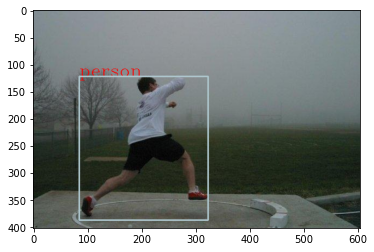

In [21]:
img_name = "FogDr_Google_501"
predict_img("./data/Image/" + img_name + ".png")

In [13]:
img_name_list = get_img_name_list()
annotations_data = get_annotations_data(img_name_list)

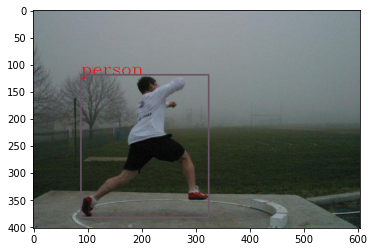

In [20]:
image = torch.Tensor(cv2.imread("./data/Image/" + img_name + ".png"))
vis_data(image, annotations_data[img_name], isPred=False)

In [ ]:
torch.cuda.empty_cache()